# Prediction of Coupon Redemption

## dependencies

In [7]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## data loading

In [8]:
offline_train = pd.read_csv("dataset/ccf_offline_stage1_train.csv")
online_train = pd.read_csv("dataset/ccf_online_stage1_train.csv")
offline_test = pd.read_csv("dataset/ccf_offline_stage1_test_revised.csv")

In [9]:
print(pd.__version__)

1.1.5


## data cleaning

In [10]:
# cast str to date time --Guangyi
online_train['Date_received'] = pd.to_datetime(online_train['Date_received'],format='%Y%m%d')
online_train['Date'] = pd.to_datetime(online_train['Date'],format='%Y%m%d')

offline_train['Date_received'] = pd.to_datetime(offline_train['Date_received'],format='%Y%m%d')
offline_train['Date'] = pd.to_datetime(offline_train['Date'],format='%Y%m%d')

offline_test['Date_received'] = pd.to_datetime(offline_test['Date_received'],format='%Y%m%d')
#offline_test['Date'] = pd.to_datetime(offline_test['Date'],format='%Y%m%d')

#get discount type
def get_discount_type(s)->str:
    s=str(s)
    if ":" in s:
        return "1"
    elif "." in s:
        return "0"
    #elif s == "fixed":
    #    return "fixed"
    else:
        return np.nan
    
#get uniform discount rate
def get_uniform_discount_rate(s)->float:
    str_value = str(s)
    rate = None
    if "." in str_value:
        rate = float(s)
    elif ":" in str_value:
        split = str_value.split(":")
#         if(len(split)==2):
        rate = float(1-float(split[1])/float(split[0]))
#         else:
#             rate = float(split[0])
    return rate

#get promotion condition
def get_promotion_condition(s)->int:
    if pd.isna(s):
        return None
    str_value = str(s)
    if ":" in str_value:
        return int(str_value.split(":")[0])
    else:
        return -1
    
#get promotion amount
def get_promotion_amount(s)->int:
    if pd.isna(s):
        return None
    str_value = str(s)
    if ":" in str_value:
        return int(str_value.split(":")[1])
    else:
        return -1

# get date gap
def get_date_diff(d1,d2):
    return (d2-d1).days

# get label(coupon was used within 15 days)
def get_label(d1,d2)->bool:
    gap = get_date_diff(d1,d2)
    if not pd.isna(gap):
        return gap<=15
    else:
        return None

def data_cleaning(df):
    df_d = df.copy()
    df_d['discount_type']=df_d['Discount_rate'].apply(get_discount_type)
    df_d['uniform_discount_rate']=df_d['Discount_rate'].apply(get_uniform_discount_rate)
    df_d['promotion_condition']=df_d['Discount_rate'].apply(get_promotion_condition)
    df_d['promotion_amonut']=df_d['Discount_rate'].apply(get_promotion_amount)
    #df_d['date_gap']=(df_d['Date']-df_d['Date_received']).apply(lambda x:x.days)
    return df_d

offline_train_d = data_cleaning(offline_train)
online_train_d = data_cleaning(online_train)
offline_test_d  = data_cleaning(offline_test)

In [11]:
## save clean data
offline_train_d.to_csv('./dataset/offline_train.csv',index=False)
offline_test_d.to_csv('./dataset/offline_test.csv',index=False)
online_train_d.to_csv('./dataset/online_train.csv',index=False)

## EDA

### label distribution 

In [6]:
offline_test_d.Date_received.describe()

count                  113640
unique                     31
top       2016-07-03 00:00:00
freq                     5491
first     2016-07-01 00:00:00
last      2016-07-31 00:00:00
Name: Date_received, dtype: object

In [7]:
offline_train_d.Date_received.describe()

count                 1053282
unique                    167
top       2016-01-29 00:00:00
freq                    71658
first     2016-01-01 00:00:00
last      2016-06-15 00:00:00
Name: Date_received, dtype: object

In [8]:
offline_train_d.Date.describe()

count                  776984
unique                    182
top       2016-03-26 00:00:00
freq                    10243
first     2016-01-01 00:00:00
last      2016-06-30 00:00:00
Name: Date, dtype: object

In [9]:
online_train_d.Date_received.describe()

count                  872357
unique                    167
top       2016-03-06 00:00:00
freq                    10873
first     2016-01-01 00:00:00
last      2016-06-15 00:00:00
Name: Date_received, dtype: object

In [10]:
online_train_d.Date.describe()

count                10773928
unique                    182
top       2016-06-18 00:00:00
freq                   112695
first     2016-01-01 00:00:00
last      2016-06-30 00:00:00
Name: Date, dtype: object

### Coupon received and redeemed in Training set

In [11]:
offline_train_d.shape

(1754884, 11)

In [12]:
print('transactions without received coupon : {}'.format(len(offline_train_d[(offline_train_d['Date'].notna()) & (offline_train_d['Coupon_id'].isna())])))
print('transactions with coupon: {}'.format(len(offline_train_d[(offline_train_d['Date'].notna()) & (offline_train_d['Coupon_id'].notna())])))
print('never used coupon: {}'.format(len(offline_train_d[(offline_train_d['Date'].isna()) & (offline_train_d['Coupon_id'].notna())])))

transactions without received coupon : 701602
transactions with coupon: 75382
never used coupon: 977900


In [13]:
coupon_used = offline_train_d[(offline_train_d['Date'].notna()) & (offline_train_d['Coupon_id'].notna())]
coupon_used['datediff'] = (coupon_used['Date'] - coupon_used['Date_received']).apply(lambda x:x.days)

In [14]:
coupon_used['label'] = coupon_used['datediff'] <= 15

(array([9.30261866e-02, 7.02878340e-02, 3.97212973e-02, 1.94253657e-02,
        1.15729993e-02, 1.01807848e-02, 5.72431637e-03, 6.73306735e-03,
        1.87240765e-03, 8.80929798e-04, 4.11100572e-04, 1.55458200e-04,
        1.41639693e-04, 1.24366560e-04, 8.29110398e-05, 3.10916399e-05,
        1.72731333e-05, 6.90925331e-06, 6.90925331e-06, 0.00000000e+00,
        3.45462666e-06, 0.00000000e+00, 3.45462666e-06, 3.45462666e-06,
        3.45462666e-06]),
 array([ 0.  ,  3.84,  7.68, 11.52, 15.36, 19.2 , 23.04, 26.88, 30.72,
        34.56, 38.4 , 42.24, 46.08, 49.92, 53.76, 57.6 , 61.44, 65.28,
        69.12, 72.96, 76.8 , 80.64, 84.48, 88.32, 92.16, 96.  ]),
 <a list of 25 Patch objects>)

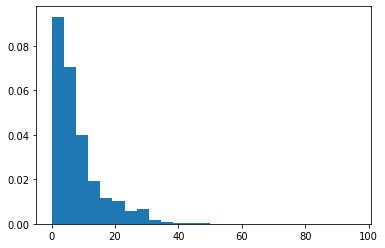

In [15]:
plt.hist(coupon_used['datediff'],bins=25,density=True)

In [16]:
coupon_used['label'].value_counts()

True     64395
False    10987
Name: label, dtype: int64

In [17]:
print('# unlabeled date(purchase without received coupon):{}'.format(701602))
print('# labeled data(with coupon Information):{}'.format((977900 + 75382)))
print('% Negative label(received coupon, but never used):{:.3%}'.format(977900/(977900 + 75382)))
print('% Positive label(received coupon, used in 15 days):{:.3%}'.format(64395/(977900 + 75382)))
print('% Neutral label:(received coupon, used after 15 days):{:.3%}'.format(10987/(977900 + 75382)))

# unlabeled date(purchase without received coupon):701602
# labeled data(with coupon Information):1053282
% Negative label(received coupon, but never used):92.843%
% Positive label(received coupon, used in 15 days):6.114%
% Neutral label:(received coupon, used after 15 days):1.043%


In [13]:
labeled = offline_train_d[offline_train_d['Coupon_id'].notna()]
def label_func(receive, use):
    if pd.isna(use):
        return 0
    datediff = (use-receive).days
    if datediff <= 15:
        return 1
    else:
        return -1
labeled['datediff'] = (labeled['Date']-labeled['Date_received']).apply(lambda x:x.days)
labeled['target'] = labeled.apply(lambda x:label_func(x.Date_received,x.Date),axis=1)

In [14]:
labeled.to_csv("dataset/train_target.csv",index=False)

In [15]:
labeled['target'].value_counts()

 0    977900
 1     64395
-1     10987
Name: target, dtype: int64

In [102]:
labeled['month_received'] = labeled['Date_received'].apply(lambda x:x.month)

month_stat = labeled.groupby(['month_received', 'label']).size().unstack(fill_value=0)

In [115]:
month_stat

label,-1,0,1
month_received,,,
1,3212,358478,9849
2,1336,126766,5331
3,921,87691,15291
4,1163,131098,5833
5,3336,190432,21580
6,1019,83435,6511


In [111]:
month_stat.div(month_stat.sum(axis=1),axis=0)

label,-1,0,1
month_received,,,
1,0.008645,0.964846,0.026509
2,0.010013,0.950035,0.039953
3,0.008864,0.843970,0.147166
4,0.008422,0.949339,0.042239
5,0.015491,0.884299,0.100210
6,0.011202,0.917221,0.071577


### users

In [30]:
offline_train_userset = set(offline_train_d.User_id.unique())
online_train_userset = set(online_train_d.User_id.unique())
offline_test_userset = set(offline_test_d.User_id.unique())

In [31]:
print('# user has offline data: {}'.format(len(offline_train_userset)))
print('# user has online data: {}'.format(len(online_train_userset)))
print('# user in test set:{}'.format(len(offline_test_userset)))

# user has offline data: 539438
# user has online data: 762858
# user in test set:76309


In [51]:
# test user in offline train data
print('% test user in offline train data: {:.3%}'.format(1
                    -len(offline_test_userset - offline_train_userset) 
                                                       / len(offline_test_userset)))

# test user in online train data
print('% test user in online train data: {:.3%}'.format(1
                    -len(offline_test_userset - online_train_userset) 
                                                       / len(offline_test_userset)))


% test user in offline train data: 99.997%
% test user in online train data: 56.553%


### merchants

In [49]:
offline_train_mset = set(offline_train_d.Merchant_id.unique())
online_train_mset = set(online_train_d.Merchant_id.unique())
offline_test_mset = set(offline_test_d.Merchant_id.unique())

In [52]:
print('# merchant has offline data: {}'.format(len(offline_train_mset)))
print('# merchant has online data: {}'.format(len(online_train_mset)))
print('# merchant in test set:{}'.format(len(offline_test_mset)))

# merchant has offline data: 8415
# merchant has online data: 7999
# merchant in test set:1559


In [53]:
# test user in offline train data
print('% test merchant in offline train data: {:.3%}'.format(1
                    -len(offline_test_mset - offline_train_mset) 
                                                       / len(offline_test_mset)))

# test user in online train data
print('% test merchant in online train data: {:.3%}'.format(1
                    -len(offline_test_mset - online_train_mset) 
                                                       / len(offline_test_mset)))


% test merchant in offline train data: 99.936%
% test merchant in online train data: 0.000%


### coupons

In [54]:
offline_train_cset = set(offline_train_d.Coupon_id.unique())
online_train_cset = set(online_train_d.Coupon_id.unique())
offline_test_cset = set(offline_test_d.Coupon_id.unique())

In [55]:
print('# coupon has offline data: {}'.format(len(offline_train_cset)))
print('# coupon has online data: {}'.format(len(online_train_cset)))
print('# coupon in test set:{}'.format(len(offline_test_cset)))

# coupon has offline data: 9739
# coupon has online data: 27748
# coupon in test set:2050


In [56]:
# test user in offline train data
print('% test coupon in offline train data: {:.3%}'.format(1
                    -len(offline_test_cset - offline_train_cset) 
                                                       / len(offline_test_cset)))

# test user in online train data
print('% test coupon in online train data: {:.3%}'.format(1
                    -len(offline_test_cset - online_train_cset) 
                                                       / len(offline_test_cset)))


% test coupon in offline train data: 54.537%
% test coupon in online train data: 0.000%


## feature engineering 

### import automated feature engineering tools
Website: https://www.featuretools.com/

Install: https://featuretools.alteryx.com/en/stable/install.html

Codes below works fine on my platform (MacOS 11.2.1, Python 3.8.5, pip 21.0.1)
``` bash
python -m pip install featuretools
python -m pip install "featuretools[complete]"
```

Doc: https://featuretools.alteryx.com/en/stable/api_reference.html

github https://github.com/alteryx/featuretools

In [2]:
import featuretools as ft
print(ft.__version__)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importli

0.23.1


In [77]:
df_train_target = pd.read_csv('dataset/train_target.csv')
df_test_target = pd.read_csv('dataset/offline_test.csv')
df_online_train = pd.read_csv('dataset/online_train.csv')
df_offline_train = pd.read_csv('dataset/offline_train.csv')

### Data Preparation

In [78]:
## merge train and test target
df_train_target.head(3)
## only use Index, Date_received, Date, datediff, target
df_train_target_digest = df_train_target[['User_id','Merchant_id','Coupon_id','Date_received','Date','datediff','target']]
df_test_target_digest = df_test_target[['User_id','Merchant_id','Coupon_id','Date_received']]
df_target_merged = pd.concat([df_train_target_digest,df_test_target_digest], axis=0, ignore_index=True)

In [79]:
df_target_merged['Month_received']=df_target_merged['Date_received'].astype('datetime64[M]')
df_target_merged['data'] = np.where(df_target_merged['target'].isna(), 'Test', 'Train')

In [80]:
## produce left table for feature engineering 
## for each month, get unique User(merchant, coupon) Index 
left_user = df_target_merged[['User_id','Month_received']].drop_duplicates()
left_merchant = df_target_merged[['Merchant_id','Month_received']].drop_duplicates()
left_coupon = df_target_merged[['Coupon_id','Month_received']].drop_duplicates()

In [81]:
df_target_merged.to_csv('./dataset/target_merged.csv', index=False)
left_user.to_csv('./dataset/user_left_feature_engineering.csv', index=False)
left_merchant.to_csv('./dataset/merchant_left_feature_engineering.csv', index=False)
left_coupon.to_csv('./dataset/coupon_left_feature_engineering.csv', index=False)

In [82]:
### right table preprocessing, maually pre-do some cross features
#### flag of using coupon when purchasing 
df_offline_train['use_coupon'] = ((df_offline_train['Coupon_id'].notna()) &(df_offline_train['Date'].notna())).astype(int)
#### flag of purchasing, user might use / not use the coupon
df_offline_train['purchase'] = df_offline_train['Date'].notna().astype(int)
#### flag of giving(for merchant) / receiving(for user) coupon, user might use / not use the coupon
df_offline_train['give_coupon'] =  (df_offline_train['Coupon_id'].notna()).astype(int)
df_offline_train['Date_received'] = pd.to_datetime(df_offline_train['Date_received'])
df_offline_train['Date'] = pd.to_datetime(df_offline_train['Date'])

### !!!Attention: the column for featuretools time cutoff and window function 
def join_date_func(x):
    if pd.notna(x.Date):
        return x.Date
    else:
        return x.Date_received
df_offline_train['join_date'] = df_offline_train.apply(lambda x:join_date_func(x),axis=1)

df_offline_train['datediff'] = (df_offline_train['Date'] - df_offline_train['Date_received'] ).apply(lambda x:x.days)

In [88]:
df_offline_train['']

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,discount_type,uniform_discount_rate,promotion_condition,promotion_amonut,use_coupon,purchase,give_coupon,join_date,datediff
894491,7051717,8415,NaN,NaN,3.0,NaT,2016-05-12,NaN,NaN,NaN,NaN,0,1,0,2016-05-12,NaN
1160526,856661,7409,NaN,NaN,0.0,NaT,2016-04-19,NaN,NaN,NaN,NaN,0,1,0,2016-04-19,NaN
1375511,1493850,8022,4700.0,20:1,0.0,2016-05-04,NaT,1.0,0.95,20.0,1.0,0,0,1,2016-05-04,NaN
1084301,5497995,760,3237.0,20:5,0.0,2016-01-27,NaT,1.0,0.75,20.0,5.0,0,0,1,2016-01-27,NaN
185808,6768936,2099,NaN,NaN,0.0,NaT,2016-02-07,NaN,NaN,NaN,NaN,0,1,0,2016-02-07,NaN


In [84]:
### params for cutoff time
months_to_produce = ['2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01']
time_window = '3 month'

### merchant feature

In [153]:
curr_cutoff =  months_to_produce[-1]
merchantset = left_merchant[left_merchant['Month_received'] == curr_cutoff]

In [154]:
es = ft.EntitySet(id='offline_merchant')
es = es.entity_from_dataframe(entity_id='merchant',
                             dataframe=merchantset.drop('Month_received',axis=1),
                             index='Merchant_id',
                             variable_types={'Merchant_id':ft.variable_types.Id})

es = es.entity_from_dataframe(entity_id='offline',
                             dataframe=df_offline_train.copy(),
                             time_index='join_date',
                              index='Transaction_id',
                             make_index=True,
                             variable_types={'Merchant_id':ft.variable_types.Id,
                                            'User_id':ft.variable_types.Id,
                                            'Coupon_id':ft.variable_types.Id,
                                            #'give_coupon':ft.variable_types.Categorical,
                                            #'use_coupon':ft.variable_types.Categorical,
                                            #'purchase':ft.variable_types.Categorical,
                                            'discount_type':ft.variable_types.Categorical})
es['offline']['give_coupon'].interesting_values=[1]
es['offline']['use_coupon'].interesting_values=[1]
es['offline']['purchase'].interesting_values=[1]
es['offline']['discount_type'].interesting_values=[0,1]
es = es.add_relationship(ft.Relationship(es['merchant']['Merchant_id'],es['offline']['Merchant_id']))

In [165]:

features_list = ft.dfs(entityset=es,
                                        target_entity='merchant',
                                        agg_primitives=['mean','count','sum','max','min','num_unique','mode'],
                                        trans_primitives=['weekday'],
                                       primitive_options={
                                           'mode': {'ignore_variables': {
                                               'offline': ['Coupon_id', 'User_id', 'give_coupon','use_coupon','purchase','discount_type']
                                           }
                                                   },
                                           'num_unique': {'ignore_variables': {
                                               'offline': [ 'give_coupon','use_coupon','purchase','discount_type', 'weekday']
                                           }
                                                   }
                                       },
                                       ignore_variables = {'offline':['join_date']},
                                       cutoff_time=pd.Timestamp(curr_cutoff),
                                       training_window=time_window,
                                       where_primitives=['count','sum','mean','mode','num_unique'],
                                        #instance_ids = [4663],
                                        include_cutoff_time=False,
                                        cutoff_time_in_index=True,
                                       features_only=True
                                      )

In [166]:
es

Entityset: offline_merchant
  Entities:
    merchant [Rows: 1559, Columns: 1]
    offline [Rows: 1754884, Columns: 17]
  Relationships:
    offline.Merchant_id -> merchant.Merchant_id

In [167]:
matries = []

for curr_cutoff in months_to_produce:
    merchantset = left_merchant[left_merchant['Month_received'] == curr_cutoff]

    es = ft.EntitySet(id='offline_merchant')
    es = es.entity_from_dataframe(entity_id='merchant',
                                 dataframe=merchantset.drop('Month_received',axis=1),
                                 index='Merchant_id',
                                 variable_types={'Merchant_id':ft.variable_types.Id})

    es = es.entity_from_dataframe(entity_id='offline',
                                 dataframe=df_offline_train.copy(),
                                 time_index='join_date',
                                  index='Transaction_id',
                                 make_index=True,
                                 variable_types={'Merchant_id':ft.variable_types.Id,
                                                'User_id':ft.variable_types.Id,
                                                'Coupon_id':ft.variable_types.Id,
                                                #'give_coupon':ft.variable_types.Categorical,
                                                #'use_coupon':ft.variable_types.Categorical,
                                                #'purchase':ft.variable_types.Categorical,
                                                'discount_type':ft.variable_types.Categorical})
    es['offline']['give_coupon'].interesting_values=[1]
    es['offline']['use_coupon'].interesting_values=[1]
    es['offline']['purchase'].interesting_values=[1]
    es['offline']['discount_type'].interesting_values=[0,1]
    es = es.add_relationship(ft.Relationship(es['merchant']['Merchant_id'],es['offline']['Merchant_id']))

    feature_matrix = ft.calculate_feature_matrix(entityset=es,
                                                 features=features_list,
                                                cutoff_time=pd.Timestamp(curr_cutoff),
                                                training_window=time_window,
                                                include_cutoff_time=False,
                                                cutoff_time_in_index=True)
    
    print(curr_cutoff + ' done!\n')
    
    matries.append(feature_matrix)

2016-04-01 done!

2016-05-01 done!

2016-06-01 done!

2016-07-01 done!



In [170]:
merchant_feature = pd.concat(matries, axis=0)
merchant_feature.shape

(11012, 160)

In [174]:
merchant_feature_remove_null = ft.selection.remove_highly_null_features(merchant_feature,pct_null_threshold=0.9)
merchant_feature_remove_null.shape

(11012, 158)

In [201]:
merchant_feature_remove_single = ft.selection.remove_single_value_features(merchant_feature_remove_null)
merchant_feature_remove_single.shape

(11012, 152)

In [204]:
merchant_feature_remove_corr = ft.selection.remove_highly_correlated_features(
    merchant_feature_remove_single,
    pct_corr_threshold=0.99)

In [206]:
merchant_feature_remove_corr.shape

(11012, 87)

In [208]:
merchant_feature_remove_single.reset_index().to_csv('./dataset/merchant_feature_total_remove_null&singal.csv',index=False)

In [209]:
merchant_feature_remove_corr.reset_index().to_csv('./dataset/merchant_feature_total_remove_highcorr.csv',index=False)

In [212]:
%ll -hrt dataset/

total 2596744
-rw-r--r--@ 1 billy  staff    10M Feb 21 22:17 ccf_offline_stage1_train.zip
-rw-r--r--@ 1 billy  staff    38M Feb 21 22:17 ccf_online_stage1_train.zip
-rw-r--r--@ 1 billy  staff    68M Feb 21 22:17 ccf_offline_stage1_train.csv
-rw-r--r--@ 1 billy  staff   460M Feb 21 22:17 ccf_online_stage1_train.csv
-rw-r--r--@ 1 billy  staff   3.9M Feb 21 22:17 ccf_offline_stage1_test_revised.csv
-rw-r--r--  1 billy  staff    87M Feb 23 12:34 offline_train.csv
-rw-r--r--  1 billy  staff   6.3M Feb 23 12:34 offline_test.csv
-rw-r--r--  1 billy  staff   405M Feb 23 12:35 online_train.csv
-rw-r--r--  1 billy  staff    67M Feb 23 12:47 train_target.csv
-rw-r--r--  1 billy  staff   213K Feb 23 13:09 user_merchant_feature_engineering.csv
-rw-r--r--  1 billy  staff   323K Feb 23 13:10 user_left_coupon_engineering.csv
-rw-r--r--  1 billy  staff    61M Feb 23 13:52 target_merged.csv
-rw-r--r--  1 billy  staff    14M Feb 23 13:52 user_left_feature_engineering.csv
-rw-r--r--  1 billy  staff   213K